# 4 - Modelagem
Nesta etapa, vamos avaliar quais modelos de regressão apresentam melhores resultados para prever a variável alvo. Iniciaremos identificando um modelo base e comparando a performance com os modelos de regressão. As métricas de avaliação serão o RMSE, MAE e R2.

In [ ]:
import pandas as pd
import numpy as np

# Analises estatisticas - Inclusao commit
from scipy import stats
from scipy.stats import shapiro
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score

# Bibliotecas para manipulação gráfica
import seaborn as sns
import matplotlib.pyplot as plt

# Definir uma semente para o gerador de números aleatórios
np.random.seed(42)

In [34]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())


Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.12.2


## Setup do notebook

- Configurações gerais do notebook. Para ignorar avisos e configurações de tema para os gráficos.
- Configurar que os gráficos sejam exibidos inline no notebook.
- Configurar a semente para os geradores de números aleatórios para garantir reprodutibilidade.

In [35]:
#Para ignorar os avisos
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style = "whitegrid")
%matplotlib inline

In [36]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Tech Challenge - Grupo 56" --iversions

Author: Tech Challenge - Grupo 56

sklearn    : 1.5.1
statsmodels: 0.14.2
scipy      : 1.13.1
xgboost    : 3.0.0
seaborn    : 0.13.2
joblib     : 1.4.2
matplotlib : 3.9.2
numpy      : 1.26.4
pandas     : 2.2.3
platform   : 1.0.8



- Modelo simples OLS para ser usado como base para medir as métricas para os demais modelos e verificar variáveis significativas
- Definir variável dependente e independentes

In [37]:
def modelo_base(dataset, var_independente, var_target):
    X = dataset[var_independente]
    y = dataset[var_target]

    X = pd.get_dummies(X, drop_first=True) 
    
    # Adicionar constante (intercepto) ao modelo
    X = sm.add_constant(X)
    
    # Ajustar modelo de regressão linear
    modelo_base = sm.OLS(y, X).fit()

    # Calcular métricas
    y_pred = modelo_base.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    return {
        "modelo": "sm.OLS statsmodels",
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    } , modelo_base


In [38]:
df_dados = pd.read_csv("data/dados_projeto_analise.csv")

In [39]:
df_dados.drop(['faixa_preco','range'], axis=1, inplace=True)

In [40]:
df_dados.shape

(986, 15)

# Modelo Base Versão 1

In [41]:
# Construindo o modelo base para servir de referência
# Variável Dependente (y) e Variáveis Independentes (X)
var_independente = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'HistoryOfCancerInFamily', 'imc', 'Age']
var_target = ['PremiumPrice']

metrica_v1, modelo_v1 = modelo_base(df_dados, var_independente, var_target)
print(metrica_v1)
# Resumo dos resultados
modelo_v1.summary()

{'modelo': 'sm.OLS statsmodels', 'RMSE': 3792.1158763250546, 'MAE': 2728.3509761522355, 'R2': 0.6312804119890592}


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           PremiumPrice   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     239.2
Date:                Thu, 22 May 2025   Prob (F-statistic):          6.64e-207
Time:                        11:50:44   Log-Likelihood:                -9524.4
No. Observations:                 986   AIC:                         1.906e+04
Df Residuals:                     978   BIC:                         1.910e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    6212.3477    704.929      8.813      0.000    4829.000    7595.695
Diabetes                 -490.8407    254.130     -1.931      0.054    -989.544       7.862
BloodPressureProblems     -23.9848    252.268     -0.095      0.924    -519.034     471.065
AnyTransplants           7802.5305    529.392     14.739      0.000    6763.655    8841.406
AnyChronicDiseases       2690.4640    318.323      8.452      0.000    2065.789    3315.139
HistoryOfCancerInFamily  2029.0294    377.782      5.371      0.000    1287.673    2770.386
imc                       143.5787     20.704      6.935      0.000     102.950     184.207
Age                       317.1432      9.146     34.675      0.000     299.195     335.092
==============================================================================
Omnibus:                      228.473   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1109.990
Skew:                           0.983   Prob(JB):                    9.31e-242
Kurtosis:                       7.812   Cond. No.                         300.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> Modelo versão 1 
>

*  Variáveis preditoras: 'Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'HistoryOfCancerInFamily', 'imc', 'Age'

# Modelo Base Versão 2

In [42]:
# Retirando valores outleirs da variável dependente
# Usando o metodo e interquartil

# Retirar os Outliers da variável target
Q1 = df_dados['PremiumPrice'].quantile(0.25)
Q3 = df_dados['PremiumPrice'].quantile(0.75)
IQR = Q3 - Q1

limite_inf_1_5 = Q1 - 1.5 * IQR
limite_sup_1_5 = Q3 + 1.5 * IQR


df_dados_modelo_filtrado = df_dados[
    (df_dados['PremiumPrice'] >= limite_inf_1_5) & 
    (df_dados['PremiumPrice'] <= limite_sup_1_5)
]
df_dados_modelo_filtrado.reset_index(drop=True, inplace=True)

In [43]:
outliers_1_5 = df_dados[(df_dados['PremiumPrice'] < limite_inf_1_5) | (df_dados['PremiumPrice'] > limite_sup_1_5)]
print(f"Limite Inferior PremiumPrice: {limite_inf_1_5}")
print(f"Limite Superior PremiumPrice: {limite_sup_1_5}")
print(f"\nRetirado {outliers_1_5.shape[0]} registros considerados outliers. Total de registros para treino do modelo {df_dados_modelo_filtrado.shape[0]}.")

Limite Inferior PremiumPrice: 10500.0
Limite Superior PremiumPrice: 38500.0

Retirado 6 registros considerados outliers. Total de registros para treino do modelo 980.


In [44]:
# Retirando as duas variáveis ('Diabetes', 'BloodPressureProblems') que não se mostrou estatisticamente significante para o modelo
# Variável Dependente (y) e Variáveis Independentes (X)
var_independente = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'HistoryOfCancerInFamily', 'imc', 'Age']
var_target = ['PremiumPrice']

metrica_v2, modelo_v2 = modelo_base(df_dados_modelo_filtrado, var_independente, var_target)
print(metrica_v2)
# Resumo dos resultados
modelo_v2.summary()

{'modelo': 'sm.OLS statsmodels', 'RMSE': 3525.9030667101624, 'MAE': 2619.05439072689, 'R2': 0.6718353718131147}


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           PremiumPrice   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     284.3
Date:                Thu, 22 May 2025   Prob (F-statistic):          3.88e-230
Time:                        11:50:44   Log-Likelihood:                -9395.1
No. Observations:                 980   AIC:                         1.881e+04
Df Residuals:                     972   BIC:                         1.885e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    6059.5307    660.137      9.179      0.000    4764.074    7354.988
Diabetes                 -412.8921    236.768     -1.744      0.081    -877.527      51.742
BloodPressureProblems    -225.3206    235.551     -0.957      0.339    -687.568     236.927
AnyTransplants           7915.0861    492.335     16.077      0.000    6948.924    8881.248
AnyChronicDiseases       2771.0266    296.878      9.334      0.000    2188.431    3353.622
HistoryOfCancerInFamily  2025.5993    352.657      5.744      0.000    1333.543    2717.655
imc                       134.2794     19.395      6.923      0.000      96.218     172.340
Age                       325.3714      8.542     38.092      0.000     308.609     342.134
==============================================================================
Omnibus:                       76.571   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.806
Skew:                           0.403   Prob(JB):                     1.24e-45
Kurtosis:                       5.101   Cond. No.                         301.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> Houve melhora na métrica R2 de 0.631 para 0.670
> 

# Modelo Base Versão 3

In [45]:
# Como analisado na etapa de análise o valor do seguro não está claro para esse grupo
# Retirar o grupo obesidade Grau III, pelo motivo de não observar variação do valor do seguro para este grupo
grupo_obesidade_III = df_dados_modelo_filtrado[(df_dados_modelo_filtrado['categoria_imc'] == 'Obesidade grau III')]
grupo_obesidade_III.shape[0]

35

In [46]:
# Retirar o grupo de Obesidade Grau III
df_dados_modelo_filtrado = df_dados_modelo_filtrado[(df_dados_modelo_filtrado['categoria_imc'] != 'Obesidade grau III')]
df_dados_modelo_filtrado.reset_index(drop=True, inplace=True)
df_dados_modelo_filtrado.shape

(945, 15)

In [47]:
# Verificar novas métricas sem o grupo obesidade grau III
# Variável Dependente (y) e Variáveis Independentes (X)
var_independente = ['AnyTransplants', 'AnyChronicDiseases', 'HistoryOfCancerInFamily', 'imc', 'Age']
var_target = ['PremiumPrice']

metrica_v3, modelo_v3 = modelo_base(df_dados_modelo_filtrado, var_independente, var_target)
print(metrica_v3)
# Resumo dos resultados
modelo_v3.summary()

{'modelo': 'sm.OLS statsmodels', 'RMSE': 3447.75751318261, 'MAE': 2566.1291343304383, 'R2': 0.677257182412091}


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           PremiumPrice   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     394.1
Date:                Thu, 22 May 2025   Prob (F-statistic):          1.10e-227
Time:                        11:50:45   Log-Likelihood:                -9038.4
No. Observations:                 945   AIC:                         1.809e+04
Df Residuals:                     939   BIC:                         1.812e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    5524.7468    704.824      7.838      0.000    4141.535    6907.959
AnyTransplants           8416.6799    498.645     16.879      0.000    7438.093    9395.267
AnyChronicDiseases       2821.5509    290.390      9.716      0.000    2251.662    3391.440
HistoryOfCancerInFamily  1991.8570    351.173      5.672      0.000    1302.682    2681.032
imc                       161.9738     22.205      7.295      0.000     118.397     205.550
Age                       313.8939      8.129     38.616      0.000     297.941     329.846
==============================================================================
Omnibus:                       70.026   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.387
Skew:                           0.353   Prob(JB):                     1.13e-44
Kurtosis:                       5.154   Cond. No.                         322.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> Houve melhora na métrica R2 de 0.670 para 0.677
> 

# Modelo Base Versão 4

In [48]:
# Criar novo modelo usando variáveis dummies
# Variável Dependente (y) e Variáveis Independentes (X)

# Transformando em variáveis dummies
df_dummies = pd.get_dummies(df_dados_modelo_filtrado, columns=['faixa_etaria'], prefix='faixa', drop_first=True)

# Renomear colunas
df_dummies.rename(columns={'faixa_Idoso': 'faixa_idoso'
                           , 'faixa_Jovem adulto': 'faixa_jovem_adulto'
                           , 'faixa_Meia-idade' : 'faixa_meia_idade' }
                  , inplace=True)

# Converte todas as colunas cujo nome começa com "faixa_" para tipo int
faixa_cols = [col for col in df_dummies.columns if col.startswith('faixa_')]
df_dummies[faixa_cols] = df_dummies[faixa_cols].astype(int)

var_independente = ['AnyTransplants', 'AnyChronicDiseases', 'HistoryOfCancerInFamily', 'imc', 'faixa_idoso',  'faixa_jovem_adulto', 'faixa_meia_idade' ]
var_target = ['PremiumPrice']

metrica_v4, modelo_v4 = modelo_base(df_dummies, var_independente, var_target)
print(metrica_v4)
# Resumo dos resultados
modelo_v4.summary()

{'modelo': 'sm.OLS statsmodels', 'RMSE': 3506.9915096801046, 'MAE': 2618.2499631663027, 'R2': 0.6660721909596595}


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           PremiumPrice   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     267.0
Date:                Thu, 22 May 2025   Prob (F-statistic):          3.55e-218
Time:                        11:50:45   Log-Likelihood:                -9054.5
No. Observations:                 945   AIC:                         1.812e+04
Df Residuals:                     937   BIC:                         1.816e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1.612e+04    647.525     24.888      0.000    1.48e+04    1.74e+04
AnyTransplants           8424.2720    508.138     16.579      0.000    7427.053    9421.491
AnyChronicDiseases       2189.4278    301.427      7.264      0.000    1597.878    2780.978
HistoryOfCancerInFamily  1833.1838    357.544      5.127      0.000    1131.505    2534.863
imc                       163.9760     22.618      7.250      0.000     119.589     208.363
faixa_idoso              7453.6800    372.251     20.023      0.000    6723.139    8184.221
faixa_jovem_adulto      -5951.7455    386.939    -15.382      0.000   -6711.114   -5192.377
faixa_meia_idade         5627.3663    271.410     20.734      0.000    5094.725    6160.008
==============================================================================
Omnibus:                       38.161   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.289
Skew:                          -0.049   Prob(JB):                     5.04e-24
Kurtosis:                       4.648   Cond. No.                         160.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

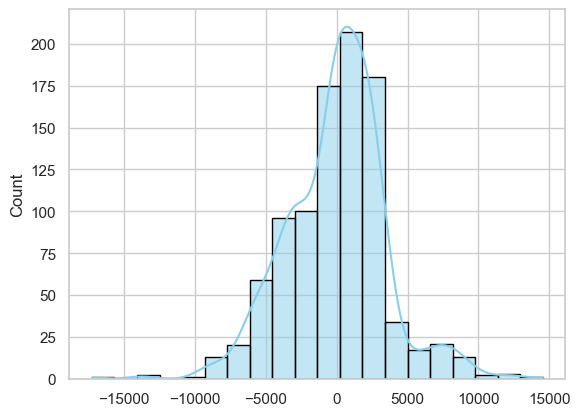

In [49]:
residuos = modelo_v4.resid
sns.histplot(residuos, kde=True, stat='count', bins=20, color='skyblue', edgecolor='black')
plt.show()

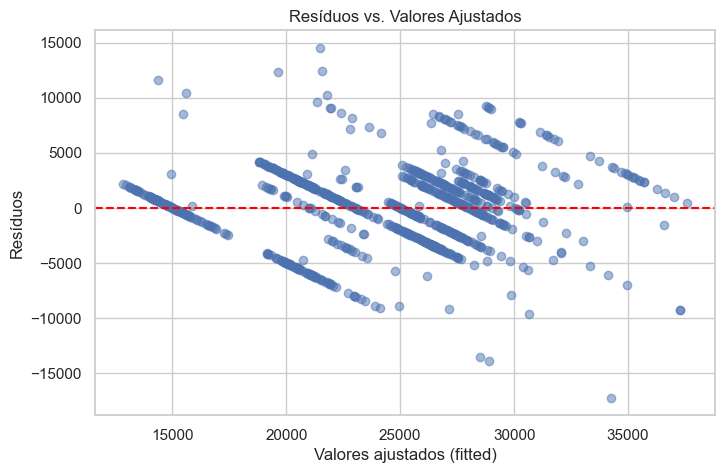

In [50]:
import matplotlib.pyplot as plt

y_pred = modelo_v4.fittedvalues
residuos = modelo_v4.resid

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuos, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valores ajustados (fitted)")
plt.ylabel("Resíduos")
plt.title("Resíduos vs. Valores Ajustados")
plt.show()


# Outros Modelos

In [59]:
# Separa features e target
var_independente = ['AnyTransplants', 'AnyChronicDiseases', 'HistoryOfCancerInFamily', 'Age', 'imc']
var_target = ['PremiumPrice']

X = df_dados_modelo_filtrado[var_independente]  
y = df_dados_modelo_filtrado[var_target]  

# Passo 1: Separar os dados em treino (60%) e temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Passo 2: Separar os dados restantes (40%) em validação (20%) e teste (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Lista de modelos
modelos = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
}

# Hiperparametros
#n_estimators  # número de árvores
#learning_rate # taxa de aprendizado
#max_depth     # profundidade máxima das árvores
#random_state  #valor da semente para reprodutibilidade

# Armazenar resultados
resultados = []

# Avaliar cada modelo
for nome, modelo in modelos.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', modelo)
    ])

    # Treinar
    pipeline.fit(X_train, y_train)

    # Previsão no conjunto de validação
    y_pred = pipeline.predict(X_val)

    # Métricas
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    # Validação cruzada
    cv_scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())

    resultados.append({
        'Modelo': nome,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'CV_RMSE' : cv_rmse
    })

# Converter em DataFrame
df_resultados = pd.DataFrame(resultados).sort_values('RMSE')
df_resultados.reset_index(drop=True, inplace=True)

# Verificar os tamanhos
print(f"Tamanho do treino: {X_train.shape[0]}")
print(f"Tamanho da validação: {X_val.shape[0]}")
print(f"Tamanho do teste: {X_test.shape[0]}")

df_resultados


     AnyTransplants  AnyChronicDiseases  HistoryOfCancerInFamily  Age  \
613               0                   0                        0   36   
278               0                   0                        0   43   
12                0                   0                        0   24   
182               0                   0                        0   20   
368               1                   1                        0   28   
..              ...                 ...                      ...  ...   
106               0                   0                        0   35   
270               0                   0                        1   32   
860               0                   0                        0   55   
435               0                   0                        0   24   
102               0                   0                        0   31   

           imc  
613  33.386558  
278  28.360352  
12   17.990153  
182  29.069767  
368  23.833005  
..         ...  
106 

,Modelo,RMSE,MAE,R2,CV_RMSE
0,XGBoost,3091.310699,1696.102234,0.761215,2826.919631
1,GradientBoosting,3107.641057,1865.717145,0.758686,2778.643699
2,RandomForest,3194.952871,1689.215168,0.744935,2715.257585
3,LinearRegression,3675.395475,2742.952317,0.662457,3398.008827
4,Lasso,3675.796555,2743.029067,0.662383,3397.962135
5,Ridge,3676.010147,2743.198623,0.662344,3396.669293


In [58]:
# Separar features e target
var_independente = ['AnyTransplants', 'AnyChronicDiseases', 'HistoryOfCancerInFamily', 'Age', 'imc']
var_target = ['PremiumPrice']

X = df_dados_modelo_filtrado[var_independente]  
y = df_dados_modelo_filtrado[var_target].values.ravel()  # necessário para evitar erro com y no scikit-learn

# Separação dos dados
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Lista de modelos
modelos = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=50, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
}

# Avaliação dos modelos
resultados = []
melhor_rmse = np.inf
melhor_modelo_nome = None
melhor_pipeline = None

for nome, modelo in modelos.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', modelo)
    ])

    # Treina o pipeline
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)

    # Métricas
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    # Validação cruzada
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_scores.mean()

    # Armazenar resultados
    resultados.append({
        'Modelo': nome,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'CV_RMSE': cv_rmse
    })

    # Verifica se este modelo é o melhor até agora
    if rmse < melhor_rmse:
        melhor_rmse = rmse
        melhor_modelo_nome = nome
        melhor_pipeline = pipeline

# Mostra os resultados
df_resultados = pd.DataFrame(resultados).sort_values('RMSE').reset_index(drop=True)
print(df_resultados)

# Usa o melhor modelo para prever no conjunto de teste
y_test_pred = melhor_pipeline.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'\n✅ Melhor modelo: {melhor_modelo_nome}')
print(f'📊 RMSE no teste: {rmse_test:.2f}')


             Modelo         RMSE          MAE        R2      CV_RMSE
0  GradientBoosting  3484.421998  2077.748750  0.692585  2586.266200
1           XGBoost  3497.103243  2096.657102  0.690343  2571.944237
2      RandomForest  3668.287907  1721.063830  0.659285  2636.540022
3  LinearRegression  4023.897936  2920.208477  0.590025  3369.186860
4             Ridge  4023.995520  2920.344284  0.590005  3369.061198
5             Lasso  4024.114606  2920.325482  0.589980  3369.155880

✅ Melhor modelo: GradientBoosting
📊 RMSE no teste: 3135.34


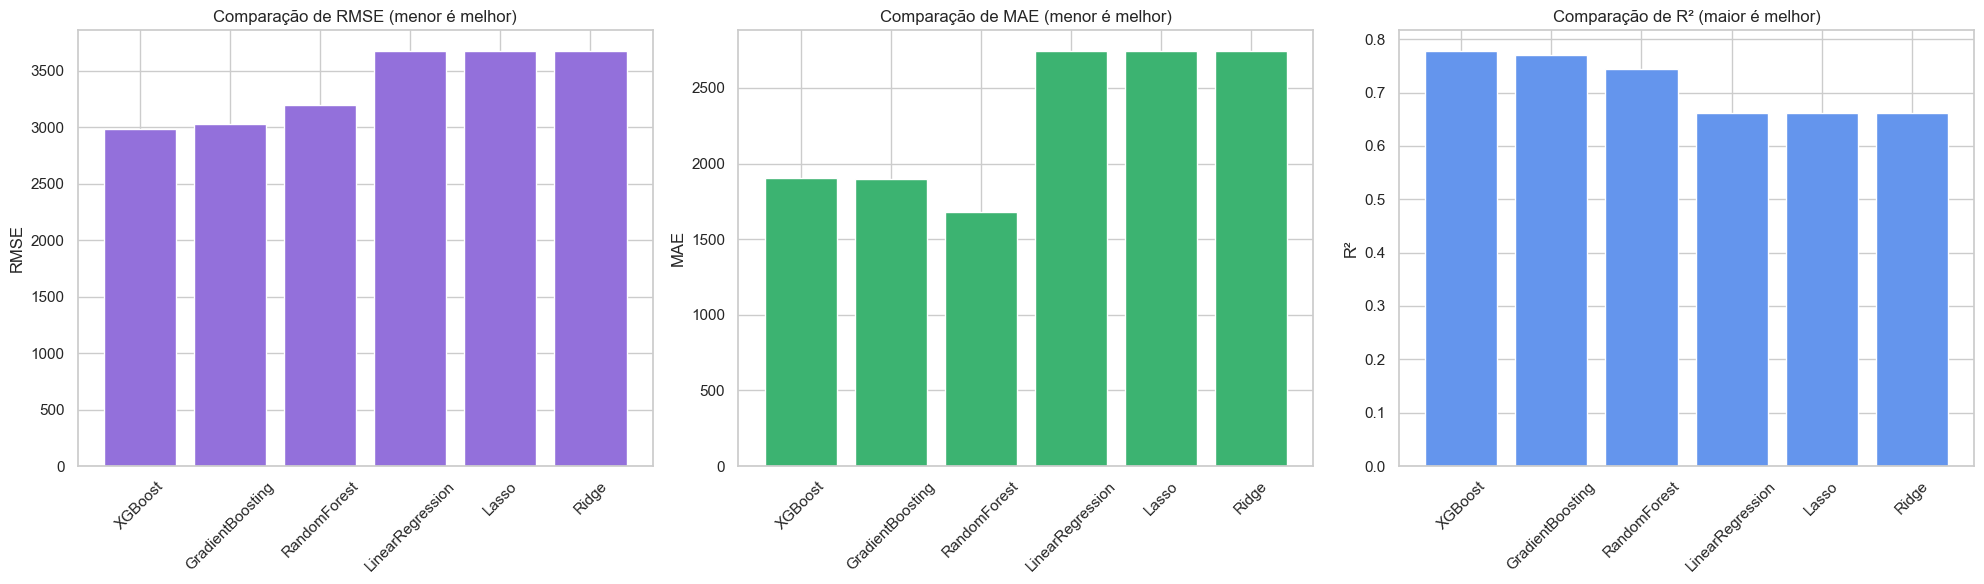

In [53]:
# Gráficos comparativos
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# RMSE
axes[0].bar(df_resultados['Modelo'], df_resultados['RMSE'], color='mediumpurple')
axes[0].set_title('Comparação de RMSE (menor é melhor)')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)

# MAE
axes[1].bar(df_resultados['Modelo'], df_resultados['MAE'], color='mediumseagreen')
axes[1].set_title('Comparação de MAE (menor é melhor)')
axes[1].set_ylabel('MAE')
axes[1].tick_params(axis='x', rotation=45)

# R²
axes[2].bar(df_resultados['Modelo'], df_resultados['R2'], color='cornflowerblue')
axes[2].set_title('Comparação de R² (maior é melhor)')
axes[2].set_ylabel('R²')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


📌 Modelo: Lasso
RMSE: 3371.86
Shapiro-Wilk p-valor: 0.0001 -> Não normal


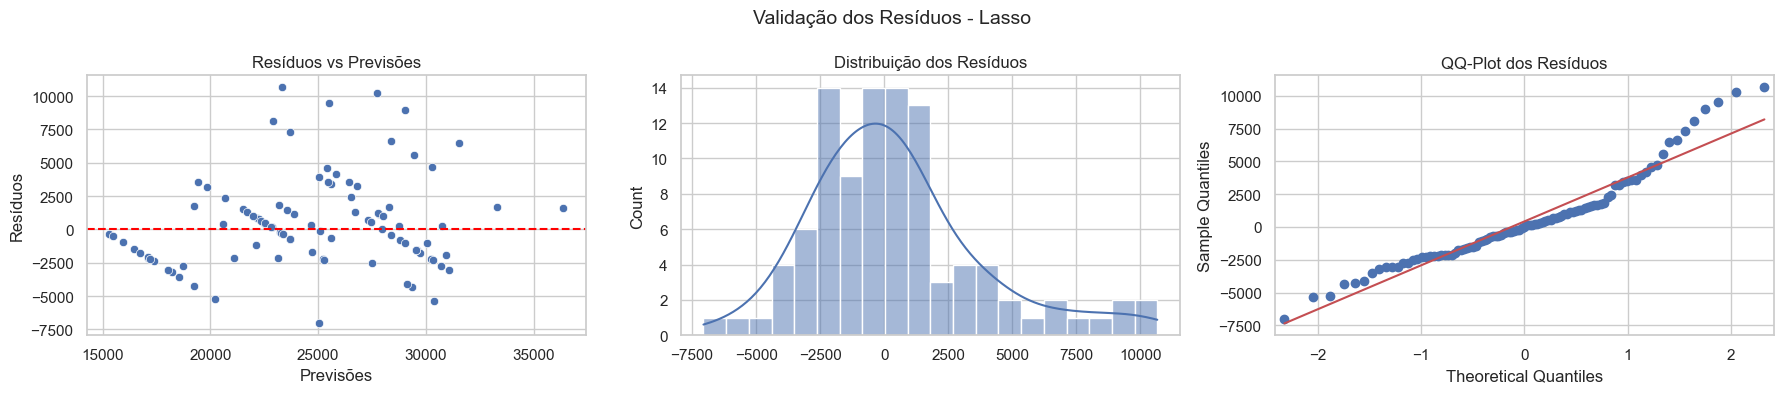


📌 Modelo: RandomForest
RMSE: 2729.51
Shapiro-Wilk p-valor: 0.0000 -> Não normal


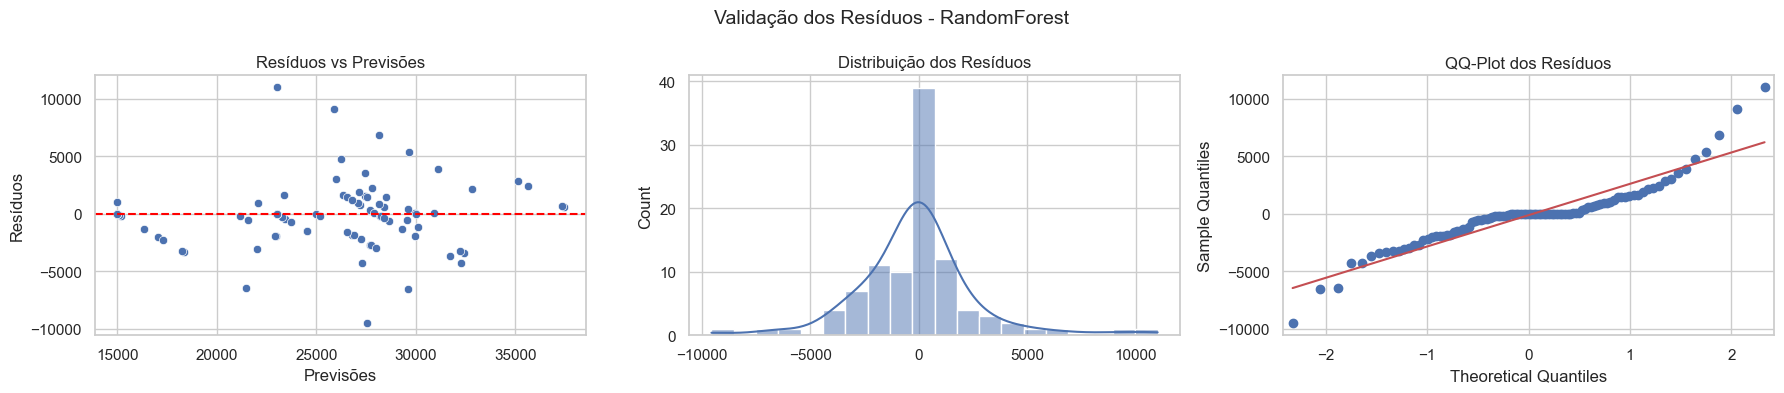


📌 Modelo: GradientBoosting
RMSE: 2383.98
Shapiro-Wilk p-valor: 0.0000 -> Não normal


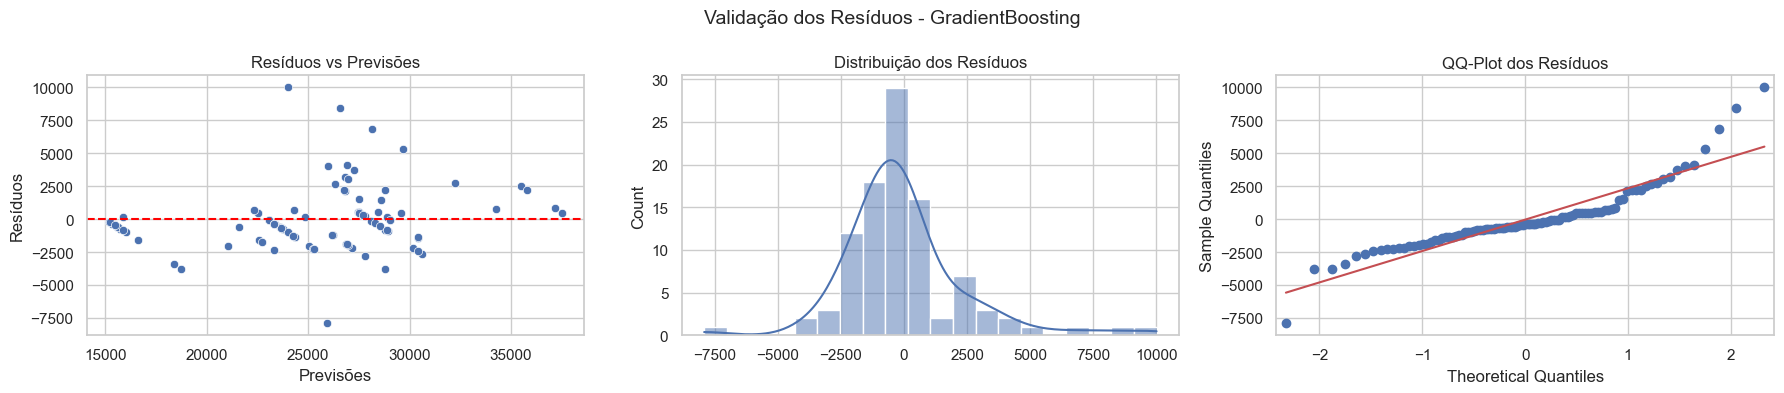


📌 Modelo: XGBoost
RMSE: 2382.69
Shapiro-Wilk p-valor: 0.0000 -> Não normal


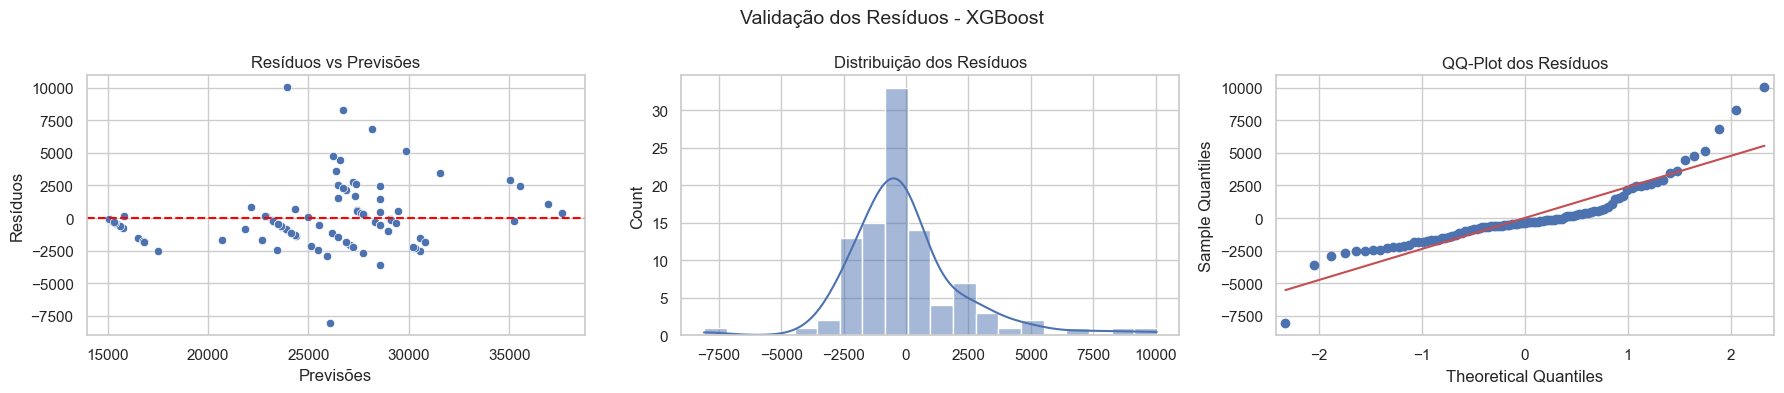

In [54]:
# Separa features e target
var_independente = [ 'AnyTransplants', 'AnyChronicDiseases', 'HistoryOfCancerInFamily', 'imc', 'Age']
var_target = ['PremiumPrice']

X = df_dados[var_independente]  
y = df_dados[var_target]  

# Passo 1: Separar os dados em treino (60%) e temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Passo 2: Separar os dados restantes (40%) em validação (20%) e teste (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Lista de modelos
modelos = {
    #'LinearRegression': LinearRegression(),
    #'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
}


# Treinar, prever e validar resíduos
for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    # Converter y_test para array 1D
    y_test_array = np.ravel(y_test)  # Garante que seja um array unidimensional
    residuos = y_test_array - y_pred  # Agora ambos têm a mesma dimensão
 
    
 #   residuos = y_test - y_pred

    print(f'\n📌 Modelo: {nome}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}')
    
    # Teste de normalidade (Shapiro-Wilk)
    stat, p = shapiro(residuos)
    print(f'Shapiro-Wilk p-valor: {p:.4f} -> {"Normal" if p > 0.05 else "Não normal"}')

    # Plots
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle(f'Validação dos Resíduos - {nome}', fontsize=14)
    
    # 1. Resíduos vs Previsões
    sns.scatterplot(x=y_pred, y=residuos, ax=axs[0])
    axs[0].axhline(0, color='red', linestyle='--')
    axs[0].set_title('Resíduos vs Previsões')
    axs[0].set_xlabel('Previsões')
    axs[0].set_ylabel('Resíduos')

    # 2. Histograma dos resíduos
    sns.histplot(residuos, bins=20, kde=True, ax=axs[1])
    axs[1].set_title('Distribuição dos Resíduos')

    # 3. QQ-plot
    sm.qqplot(residuos, line='s', ax=axs[2])
    axs[2].set_title('QQ-Plot dos Resíduos')

    plt.tight_layout()
    plt.show()

In [55]:
# Extrair o modelo XGBoost de dentro do pipeline
modelo_xgb = melhor_pipeline.named_steps['regressor']

# Verificar se é mesmo o XGBoost (opcional, mas seguro)
if isinstance(modelo_xgb, XGBRegressor):
    # Obter importâncias
    xgb_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': modelo_xgb.feature_importances_
    }).sort_values('Importance', ascending=False)

    print(xgb_importance)
else:
    print("⚠️ O melhor modelo não é o XGBoost, portanto não tem feature_importances_.")


                   Feature  Importance
3                      imc    0.589087
0           AnyTransplants    0.172574
1       AnyChronicDiseases    0.108005
2  HistoryOfCancerInFamily    0.080232
4                      Age    0.050102


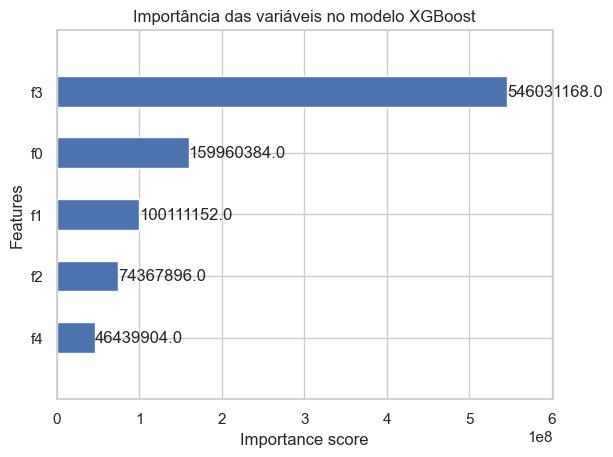

In [56]:
from xgboost.plotting import plot_importance

melhor_modelo = melhor_pipeline.named_steps['regressor']

plot_importance(melhor_modelo, importance_type='gain', max_num_features=10, height=0.5)
plt.title("Importância das variáveis no modelo XGBoost")
plt.show()


# Salvar o melhor modelo

In [57]:
import joblib

# exportando a pipeline inteira para conter o preprocessamento e o modelo
joblib.dump(melhor_pipeline, './model/melhor_modelo.pkl')  # Salvar modelo

# Para carregar o modelo salvo
modelo_carregado = joblib.load('model/melhor_modelo.pkl')